In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ml_mr.utils.mdn import MixtureDensityNetwork

In [45]:
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [20]:
n = 100_000
xs = np.linspace(-2, 2, n)
ys = 5 * xs * np.sin(3 * xs) + 0.2 * np.exp(xs) + np.random.randn(n)

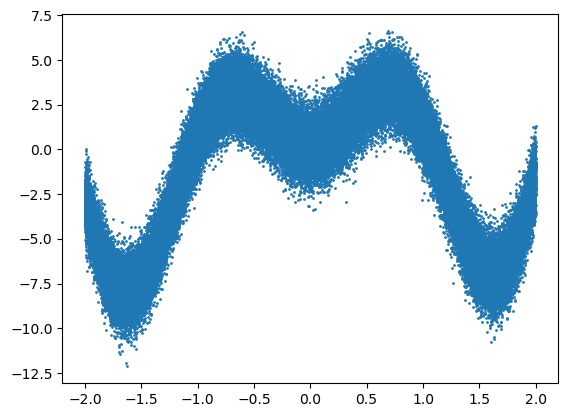

In [21]:
plt.scatter(xs, ys, s=1)

In [82]:
dataset = TensorDataset(
    torch.tensor(xs).reshape(-1, 1).float(),
    torch.tensor(ys).reshape(-1, 1).float()
)
dl = DataLoader(dataset, shuffle=True, batch_size=20_000)

In [89]:
model = MixtureDensityNetwork(
    input_size=1,
    hidden=[128, 64],
    n_components=3,
    lr=1e-3
)

In [90]:
trainer = pl.Trainer(
    max_epochs=500,
    callbacks=pl.callbacks.early_stopping.EarlyStopping(
        monitor="nll",
        patience=10
    ),
    log_every_n_steps=1
)
trainer.fit(model, dl)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/legaultm/mlenv3/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name      | Type       | Params
-----------------------------------------
0 | mlp       | Sequential | 8.5 K 
1 | pi        | Linear     | 195   
2 | log_sigma | Linear     | 195   
3 | mu        | Linear     | 195   
-----------------------------------------
9.1 K     Trainable params
0         Non-trainable params
9.1 K     Total params
0.036     Total estimated model params size (MB)
/home/legaultm/mlenv3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottlenec

Training: 0it [00:00, ?it/s]

In [91]:
import matplotlib.pyplot as plt

def identity_line(ax=None, ls='--', *args, **kwargs):
    # see: https://stackoverflow.com/q/22104256/3986320
    ax = ax or plt.gca()
    identity, = ax.plot([], [], ls=ls, *args, **kwargs)
    def callback(axes):
        low_x, high_x = ax.get_xlim()
        low_y, high_y = ax.get_ylim()
        low = min(low_x, low_y)
        high = max(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(ax)
    ax.callbacks.connect('xlim_changed', callback)
    ax.callbacks.connect('ylim_changed', callback)
    return ax

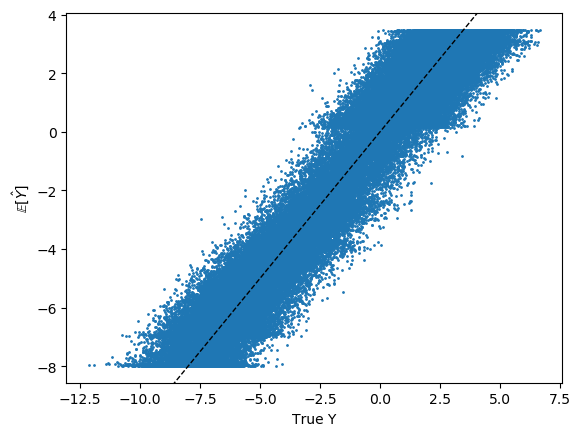

In [116]:
@torch.no_grad()
def _plot_expected():
    pi, mu, sigma = model.forward_parameters(dataset.tensors[0])
    
    # Expected value.
    y_hat = torch.sum(F.gumbel_softmax(pi, dim=1) * mu, dim=1)
    
    plt.scatter(ys, y_hat.numpy(), s=1)
    identity_line(color="black", lw=1)
    plt.xlabel("True Y")
    plt.ylabel(r"$\mathbb{E}[\hat{Y}]$")
    
_plot_expected()

In [93]:
def normal_log_density(x, mu, sigma):
    return (
        -np.log(sigma)
        -np.log(np.sqrt(2 * np.pi))
        -1/(2 * sigma ** 2) * (x - mu) ** 2 
    )

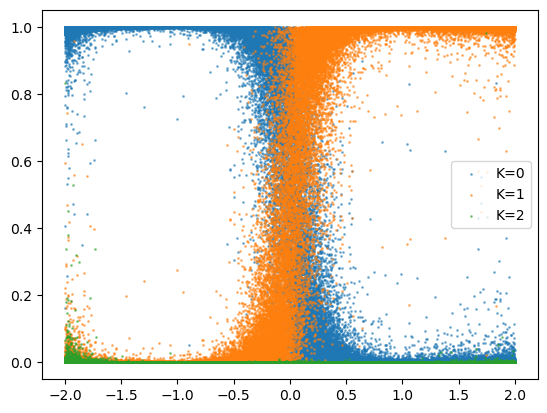

In [105]:
# What do the mixing coefficients looks like as a function of x.
@torch.no_grad()
def _plot_normals():
    pi, mus, sigmas = model.forward_parameters(dataset.tensors[0])
    ps = F.gumbel_softmax(pi, dim=1)
    
    for k in range(mus.size(1)):
        plt.scatter(
            xs,
            ps[:, k].numpy(),
            label=f"K={k}",
            s=1,
            alpha=0.5
        )
    plt.legend()

_plot_normals()

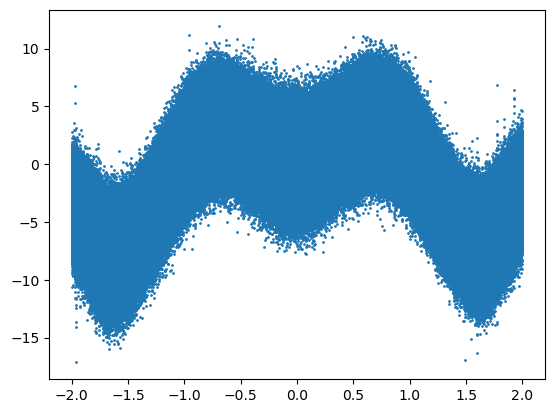

In [115]:
# Now we'll sample some y per x and use the 
@torch.no_grad()
def _sample():
    pis, mus, sigmas = model.forward_parameters(dataset.tensors[0])
    
    samples = model.sample(pis, mus, sigmas, 50).flatten().numpy()
    
    plt.scatter(
        np.repeat(xs, 50),
        samples,
        s=1
    )

_sample()

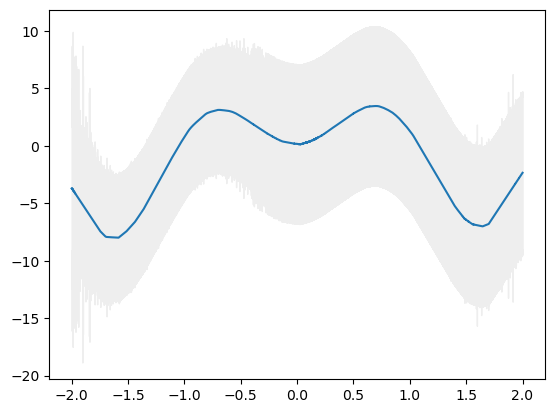

In [145]:
# And we'll plot the expected value of Y and its variance
# Now we'll sample some y per x and use the 
@torch.no_grad()
def _pred():
    pis, mus, sigmas = model.forward_parameters(dataset.tensors[0])
    
    ps = F.gumbel_softmax(pis, dim=1)
    expect_y = torch.sum(ps * mus, dim=1, keepdim=True)
    
    # See bishop eq 5.160
    zz = sigmas + torch.norm(mus - expect_y, 2, dim=0).reshape(1, -1) ** 2
    s2 = torch.sum(ps * zz, dim=1).numpy()
    
    expect_y = expect_y.numpy().flatten()
    
    plt.plot(
        xs,
        expect_y
    )
    plt.fill_between(
        xs,
        expect_y - 1.96 * np.sqrt(s2),
        expect_y + 1.96 * np.sqrt(s2),
        color="#eeeeee",
        zorder=-1
    )


_pred()